<a href="https://colab.research.google.com/github/sgevatschnaider/IA-Teoria-Practica/blob/main/notebooks/TIPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


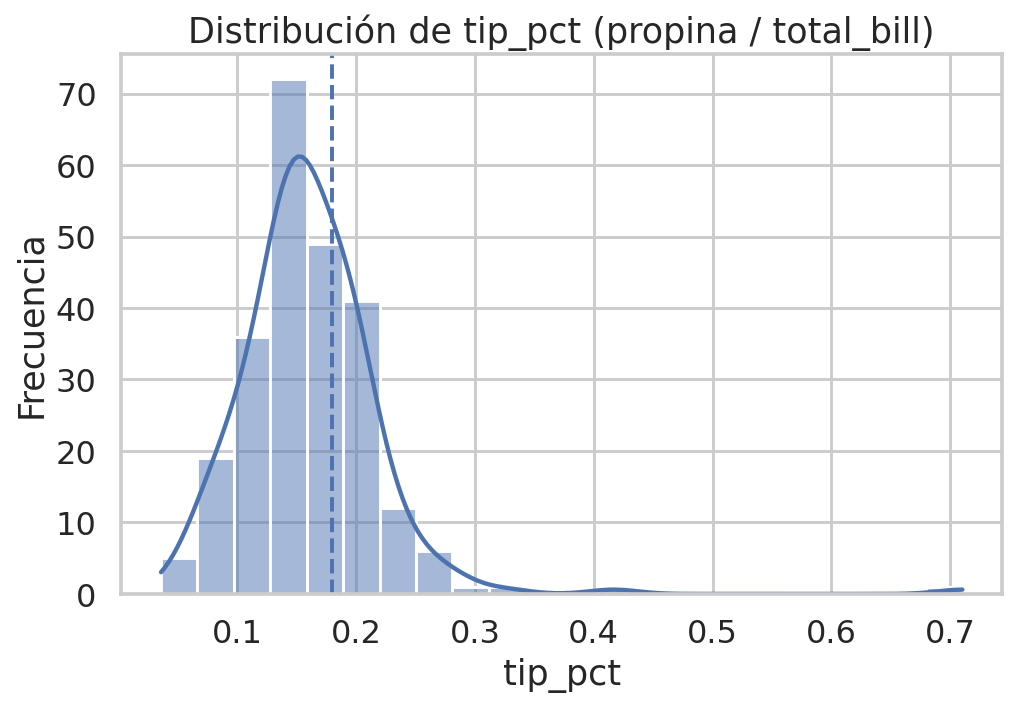
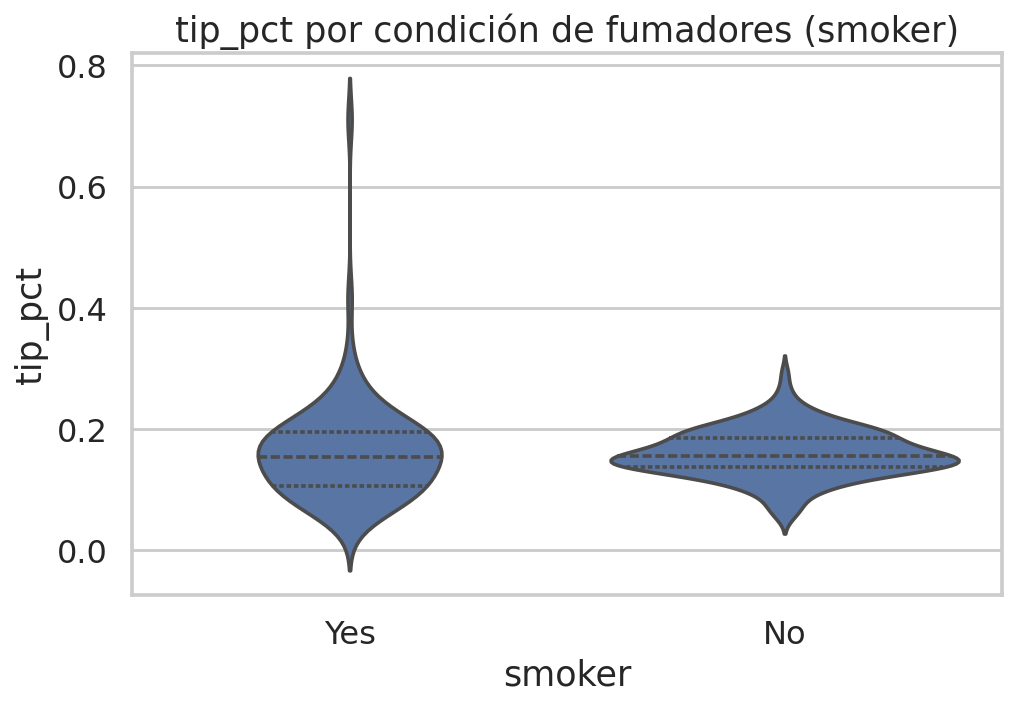
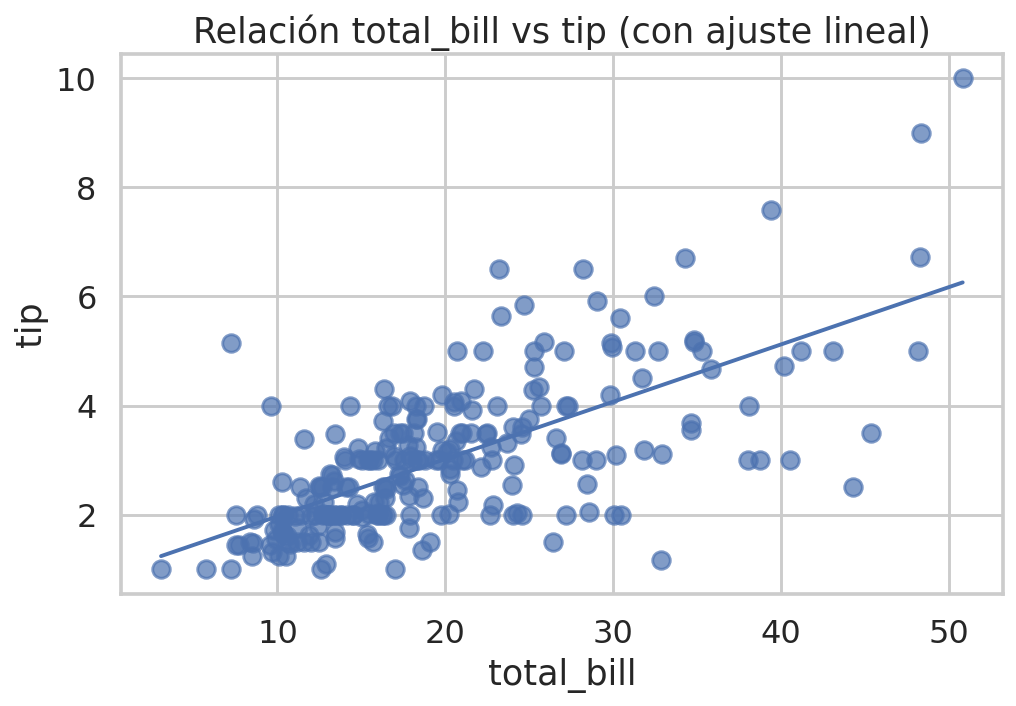
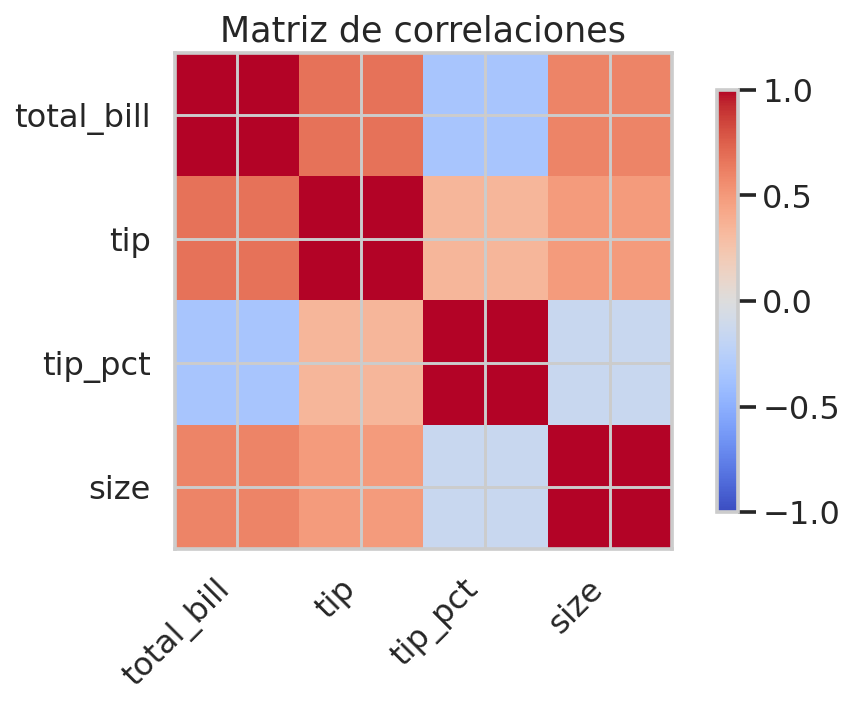

In [23]:
# -*- coding: utf-8 -*-
# ============================================================
# Análisis Predictivo: Propinas (Tips) — Dashboard HTML interactivo (compat)
# ============================================================

from IPython.display import display, HTML
import io, base64, textwrap, warnings
warnings.filterwarnings("ignore")

# ----------------- Dependencias científicas -----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# ----------------- Estética global -----------------
sns.set_theme(context="talk", style="whitegrid")
plt.rcParams["figure.figsize"] = (7.6, 5.4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

def fig_to_base64():
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png", dpi=140, bbox_inches="tight")
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("ascii")

def table_html(df: pd.DataFrame, index=False):
    return df.to_html(index=index, classes="table table-striped", border=0)

def safe_ohe_feature_names(ohe: OneHotEncoder, input_features):
    """Compat con versiones viejas/nuevas de sklearn."""
    try:
        return list(ohe.get_feature_names_out(input_features))
    except AttributeError:
        return list(ohe.get_feature_names(input_features))

# ----------------- 1) Carga de datos -----------------
try:
    df = sns.load_dataset("tips").copy()
except Exception as e:
    raise RuntimeError("No se pudo cargar 'tips' desde seaborn. Verifica tu entorno.") from e

# Documentación breve del dataset
dataset_description = textwrap.dedent("""
- **Contexto**: Propinas en un restaurante (total de la cuenta, propina, sexo, fumador, día, horario, tamaño de mesa).
- **Variables clave**:
  - `total_bill` (float): total de la cuenta.
  - `tip` (float): propina absoluta.
  - `sex` (cat): sexo del pagador.
  - `smoker` (cat): si en la mesa había fumadores.
  - `day` (cat): día de la semana (Thur–Sun).
  - `time` (cat): Lunch o Dinner.
  - `size` (int): tamaño del grupo.
""").strip()

# ----------------- 2) Feature engineering -----------------
df["tip_pct"] = df["tip"] / df["total_bill"]
threshold = 0.18   # 18% como propina "generosa"
df["generous_tip"] = (df["tip_pct"] >= threshold).astype(int)

# ----------------- 3) EDA y Gráficos -----------------
# 3.1 Distribución de tip_pct
sns.histplot(df["tip_pct"], bins=22, kde=True)
plt.axvline(0.18, linestyle="--", linewidth=2)
plt.title("Distribución de tip_pct (propina / total_bill)")
plt.xlabel("tip_pct")
plt.ylabel("Frecuencia")
img_hist_tip_pct = fig_to_base64()

# 3.2 Violin de tip_pct por smoker
fig, ax = plt.subplots()
sns.violinplot(x="smoker", y="tip_pct", data=df, inner="quartile", ax=ax)
ax.set_title("tip_pct por condición de fumadores (smoker)")
img_box_smoker = fig_to_base64()

# 3.3 Scatter total_bill vs tip con línea de tendencia
plt.scatter(df["total_bill"], df["tip"], alpha=0.7)
z = np.polyfit(df["total_bill"], df["tip"], 1)
p = np.poly1d(z)
x_line = np.linspace(df["total_bill"].min(), df["total_bill"].max(), 120)
plt.plot(x_line, p(x_line), linewidth=2)
plt.title("Relación total_bill vs tip (con ajuste lineal)")
plt.xlabel("total_bill")
plt.ylabel("tip")
img_scatter = fig_to_base64()

# 3.4 Correlaciones (numéricas)
corr = df[["total_bill","tip","tip_pct","size"]].corr()
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(shrink=0.85)
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de correlaciones")
img_corr = fig_to_base64()

# ----------------- 4) Preparación para modelado -----------------
numeric_features = ["total_bill", "size"]
categorical_features = ["sex", "smoker", "day", "time"]

# --------------- REGRESIÓN: predecir tip_pct ----------------
X_reg = df[numeric_features + categorical_features]
y_reg = df["tip_pct"]

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

models_reg = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
}

metrics_rows_reg = []
feature_importances_reg = {}

for name, model in models_reg.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    pipe = Pipeline(steps=[("prep", preprocess_reg), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_test, y_pred)
    metrics_rows_reg.append([name, mae, rmse, r2])

    if hasattr(pipe.named_steps["model"], "feature_importances_"):
        ohe = pipe.named_steps["prep"].named_transformers_["cat"]
        cat_names = safe_ohe_feature_names(ohe, categorical_features)
        feat_names = numeric_features + list(cat_names)
        importances = pipe.named_steps["model"].feature_importances_
        fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
        fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
        feature_importances_reg[name] = fi_df

metrics_reg_df = pd.DataFrame(
    metrics_rows_reg, columns=["Modelo", "MAE", "RMSE", "R²"]
)

# ---------------- CLASIFICACIÓN: generous_tip >= 18% -------------
X_clf = df[numeric_features + categorical_features]
y_clf = df["generous_tip"].astype(int)

preprocess_clf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

models_clf = {
    "LogisticRegression": LogisticRegression(max_iter=200, solver="lbfgs"),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=200, random_state=42),
}

metrics_rows_clf = []
cm_tables = {}
feature_importances_clf = {}

for name, model in models_clf.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
    )
    pipe = Pipeline(steps=[("prep", preprocess_clf), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    metrics_rows_clf.append([name, acc, prec, rec, f1])

    cm = confusion_matrix(y_test, y_pred)
    cm_df_local = pd.DataFrame(cm, index=["Real:0","Real:1"], columns=["Pred:0","Pred:1"])
    cm_tables[name] = cm_df_local

    if hasattr(pipe.named_steps["model"], "feature_importances_"):
        ohe = pipe.named_steps["prep"].named_transformers_["cat"]
        cat_names = safe_ohe_feature_names(ohe, categorical_features)
        feat_names = numeric_features + list(cat_names)
        importances = pipe.named_steps["model"].feature_importances_
        fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
        fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
        feature_importances_clf[name] = fi_df

metrics_clf_df = pd.DataFrame(
    metrics_rows_clf, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"]
)

# ----------------- Tablas HTML -----------------
html_metrics_reg = table_html(metrics_reg_df.round(4))
html_metrics_clf = table_html(metrics_clf_df.round(4))
html_cm = "".join(
    f"<h4>{name}</h4>" + table_html(cm_df.round(0), index=True)
    for name, cm_df in cm_tables.items()
)

# ----------------- Importancias (tablas) -----------------
def importances_section(imp_dict, title):
    if not imp_dict:
        return f"<p>No hay importancias disponibles para {title}.</p>"
    parts = []
    for name, fi in imp_dict.items():
        parts.append(f"<h4>{name}</h4>" + table_html(fi.head(12).round(5), index=False))
    return "\n".join(parts)

html_imp_reg = importances_section(feature_importances_reg, "regresión")
html_imp_clf = importances_section(feature_importances_clf, "clasificación")

# ----------------- Imágenes Base64 (EDA) -----------------
img_tag = lambda b64: f'<img src="data:image/png;base64,{b64}" alt="plot" style="max-width:100%;border-radius:12px;box-shadow:0 10px 30px rgba(0,0,0,0.15);margin:0.6rem 0;">'

# ----------------- Links -----------------
kaggle_url = "https://www.kaggle.com/datasets/sakshisatre/tips-dataset/data"

# ----------------- Teoría (HTML, no Markdown) -----------------
theory_html = """
<h3>Teoría sobre propinas (drivers y economía del comportamiento)</h3>
<ul>
  <li><strong>Norma social</strong>: en EE. UU. y entornos similares, existe una ancla cultural (15–20%) que guía la propina base.</li>
  <li><strong>Señales y reciprocidad</strong>: calidad de servicio percibida, amabilidad y contacto visual aumentan la propensión a propinar (reciprocidad).</li>
  <li><strong>Tamaño de grupo</strong> (<em>size</em>) y cuenta total (<em>total_bill</em>): a mayor monto y mayor grupo, sube la propina absoluta, pero la <strong>tasa</strong> (<code>tip_pct</code>) puede bajar por “difusión de responsabilidad”.</li>
  <li><strong>Contexto temporal</strong> (<em>time</em>, <em>day</em>): cenas y fines de semana suelen asociarse a cuentas más altas y diferente composición de clientes.</li>
  <li><strong>Sesgos cognitivos</strong>: anclaje por montos redondos, menor “pain of paying” con tarjeta, promociones que alteran la percepción de servicio.</li>
</ul>

<h3>Paradigma EDA aplicado a <em>Tips</em></h3>
<ol>
  <li><strong>Planteo</strong>: ¿Qué explica <code>tip_pct</code> y qué señales anticipan propina ≥ 18%?</li>
  <li><strong>Univariado</strong>: distribución de <code>tip_pct</code> para colas/asimetrías y fijar umbrales.</li>
  <li><strong>Bivariado</strong>: <code>total_bill</code>–<code>tip</code>, y <code>smoker/time/day</code> vs <code>tip_pct</code>.</li>
  <li><strong>Multivariado</strong>: correlaciones numéricas, <em>one-hot</em> en categóricas, interacción plausible <code>total_bill × time</code>.</li>
  <li><strong>Modelado rápido</strong>: regresión lineal como <em>baseline</em>; árboles/bosques para no linealidades.</li>
  <li><strong>Validación</strong>: <em>holdout</em> estratificado; MAE/RMSE/R² vs Acc/Prec/Rec/F1.</li>
  <li><strong>Iteración</strong>: nuevas variables (redondeo, bebidas), regularización y <em>tuning</em>.</li>
</ol>
""".strip()

# ----------------- DASHBOARD HTML -----------------
html = f"""
<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>
<title>Índice: Análisis Predictivo — Tips</title>
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700;800&family=JetBrains+Mono:wght@300;400;500&display=swap" rel="stylesheet">
<link href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css" rel="stylesheet">
<style>
  :root {{
    --bg-primary: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    --bg-secondary: rgba(255, 255, 255, 0.95);
    --bg-tertiary: rgba(248, 250, 252, 0.8);
    --bg-card: rgba(255, 255, 255, 0.1);
    --text-primary: #1a202c;
    --text-secondary: #4a5568;
    --text-light: #ffffff;
    --accent-primary: #667eea;
    --accent-secondary: #764ba2;
    --accent-gradient: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    --border-color: rgba(255, 255, 255, 0.2);
    --shadow-card: 0 20px 40px rgba(0, 0, 0, 0.1);
    --shadow-hover: 0 30px 60px rgba(0, 0, 0, 0.15);
    --shadow-glow: 0 0 30px rgba(102, 126, 234, 0.3);
    --border-radius: 16px;
    --transition: all 0.4s cubic-bezier(0.25, 0.8, 0.25, 1);
  }}
  [data-theme="dark"] {{
    --bg-primary: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%);
    --bg-secondary: rgba(26, 32, 44, 0.95);
    --bg-tertiary: rgba(45, 55, 72, 0.8);
    --bg-card: rgba(255, 255, 255, 0.05);
    --text-primary: #f7fafc;
    --text-secondary: #cbd5e0;
    --text-light: #ffffff;
    --accent-primary: #63b3ed;
    --accent-secondary: #9f7aea;
    --accent-gradient: linear-gradient(135deg, #63b3ed 0%, #9f7aea 100%);
    --border-color: rgba(255, 255, 255, 0.1);
    --shadow-glow: 0 0 30px rgba(99, 179, 237, 0.3);
  }}
  * {{ margin:0; padding:0; box-sizing:border-box; }}
  html {{ scroll-behavior:smooth; }}
  body {{
    font-family: 'Inter', sans-serif;
    line-height: 1.7;
    background: var(--bg-primary);
    color: var(--text-primary);
    min-height: 100vh;
    overflow-x: hidden;
    transition: var(--transition);
  }}

  .container {{ max-width: 1100px; margin: 0 auto; padding: 2rem 1rem; position: relative; z-index: 1; }}
  .header {{ text-align:center; margin-bottom: 2rem; }}
  .main-title {{
    font-size: clamp(2.4rem, 6vw, 3.6rem);
    font-weight: 800;
    background: var(--accent-gradient);
    -webkit-background-clip: text; -webkit-text-fill-color: transparent; background-clip: text;
    margin-bottom: .75rem;
  }}
  .subtitle {{ font-size: 1.1rem; color: var(--text-light); opacity: .9; }}
  .btn-row {{ display:flex; gap: .8rem; justify-content:center; margin-top: 1.2rem; flex-wrap: wrap; }}
  .btn {{
    border: 2px solid var(--border-color);
    background: var(--bg-secondary);
    color: var(--text-primary);
    padding: .8rem 1.2rem; border-radius: 999px; text-decoration:none; font-weight:600;
    box-shadow: var(--shadow-card);
    transition: var(--transition);
    display:inline-flex; align-items:center; gap:.6rem;
  }}
  .btn:hover {{ transform: translateY(-2px); box-shadow: var(--shadow-hover), var(--shadow-glow); }}

  .theme-toggle {{
    position: fixed; top: 1rem; right: 1rem; width: 56px; height: 56px;
    border: none; border-radius: 50%; background: var(--bg-secondary);
    backdrop-filter: blur(20px); box-shadow: var(--shadow-card);
    cursor: pointer; display:flex; align-items:center; justify-content:center;
    font-size: 1.2rem; color: var(--accent-primary); transition: var(--transition);
    z-index: 1000; border: 2px solid var(--border-color);
  }}
  .theme-toggle:hover {{ transform: scale(1.06) rotate(180deg); box-shadow: var(--shadow-hover), var(--shadow-glow); }}

  .section-card {{
    background: var(--bg-secondary); backdrop-filter: blur(20px);
    border-radius: var(--border-radius); margin-bottom: 1.2rem;
    box-shadow: var(--shadow-card); border: 1px solid var(--border-color);
    overflow: hidden; transition: var(--transition); position: relative;
  }}
  .section-card:hover {{ box-shadow: var(--shadow-hover); transform: translateY(-6px); }}
  .section-header {{
    background: none; border: none; width: 100%; padding: 1.2rem 1.6rem;
    text-align:left; cursor:pointer; display:flex; align-items:center; justify-content:space-between;
    font-size: 1.15rem; font-weight: 700; color: var(--text-primary);
  }}
  .expand-icon {{ color: var(--text-secondary); transition: var(--transition); font-size: 1.1rem; }}
  .section-header[aria-expanded="true"] .expand-icon {{ transform: rotate(180deg); color: var(--accent-primary); }}
  .section-title {{ display:flex; align-items:center; gap:.8rem; }}
  .section-icon {{
    background: var(--accent-gradient); -webkit-background-clip:text; -webkit-text-fill-color: transparent; background-clip:text;
    font-size: 1.3rem; width: 26px; text-align:center;
  }}

  .section-content {{
    max-height: 0; overflow: hidden; opacity: 0;
    transition: max-height .5s cubic-bezier(.25,.8,.25,1), padding .5s cubic-bezier(.25,.8,.25,1), opacity .35s ease;
    background: var(--bg-tertiary); font-size: 1rem;
  }}
  .section-content.expanded {{ max-height: 2400px; padding: 1rem 1.6rem 1.4rem 1.6rem; opacity: 1; border-top: 1px solid var(--border-color); }}
  .content-block {{ margin: .6rem 0; }}

  .tabbar {{ display:flex; gap:.6rem; flex-wrap:wrap; margin:.4rem 0 1rem 0; }}
  .tab {{ padding:.5rem .9rem; border-radius: 12px; border:1px solid var(--border-color); cursor:pointer; background: var(--bg-secondary); font-weight:600; }}
  .tab.active {{ box-shadow: var(--shadow-glow); }}

  .table {{ width:100%; border-collapse: collapse; font-size:.94rem; }}
  .table th, .table td {{ padding:.5rem .6rem; border-bottom: 1px solid #e5e7eb; }}
  .table tr:hover td {{ background: rgba(0,0,0,.03); }}

  .footer {{ text-align:center; margin: 1.6rem 0 0.4rem; opacity:.85; font-size:.95rem; }}
  .small-note {{ text-align:center; font-size:.9rem; opacity:.75; margin-top:.3rem; }}
</style>
</head>
<body>
  <button class="theme-toggle" onclick="toggleTheme()" title="Cambiar tema" aria-label="Cambiar tema">
    <i class="fas fa-moon" id="theme-icon"></i>
  </button>

  <div class="container">
    <header class="header">
      <h1 class="main-title">Análisis Predictivo: Propinas (Tips)</h1>
      <p class="subtitle">Pipeline completo: EDA → Regresión (tip_pct) → Clasificación (≥ 18%)</p>
      <div class="btn-row">
        <a class="btn" href="{kaggle_url}" target="_blank" rel="noopener">
          <i class="fa-brands fa-kaggle"></i> Ir al dataset en Kaggle
        </a>
      </div>
    </header>

    <!-- Sección 1: Descripción y Carga -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-database section-icon"></i> Configuración y Carga de Datos</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="content-block">
          <p>Este dashboard utiliza el dataset <b>Tips</b> de Seaborn/Kaggle para modelar y explicar la propina como proporción de la cuenta (<code>tip_pct</code>) y la probabilidad de dar una propina <i>generosa</i> (≥ 18%).</p>
          <pre style="white-space:pre-wrap;background:rgba(0,0,0,.04);padding:.8rem;border-radius:12px;border:1px solid #e5e7eb;">{dataset_description}</pre>
        </div>
      </div>
    </div>

    <!-- Sección 2: EDA -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-chart-bar section-icon"></i> Análisis Exploratorio (EDA)</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="content-block">
          <h3>Distribuciones & Relaciones</h3>
          {img_tag(img_hist_tip_pct)}
          {img_tag(img_box_smoker)}
          {img_tag(img_scatter)}
          {img_tag(img_corr)}
          <ul style="margin-top:.6rem;padding-left:1rem;">
            <li><b>tip_pct</b> concentra la mayoría entre 10–20% con cola hacia valores mayores.</li>
            <li>Mesas con <b>fumadores</b> muestran leve variación en la mediana de <b>tip_pct</b>.</li>
            <li><b>total_bill</b> se relaciona positivamente con <b>tip</b>, pero con dispersión (efecto tamaño del grupo).</li>
          </ul>
        </div>
      </div>
    </div>

    <!-- Sección 3: Regresión -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-square-root-alt section-icon"></i> Regresión: predecir tip_pct</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="tabbar">
          <div class="tab active">Métricas</div>
        </div>
        <div class="content-block">
          {html_metrics_reg}
        </div>
        <div class="content-block">
          <h3>Importancias de Variables (modelos con árbol)</h3>
          {html_imp_reg}
        </div>
        <div class="content-block" style="opacity:.9;">
          <p><b>Lectura:</b> MAE y RMSE informan error promedio/raíz cuadrática; R² mide qué fracción de la varianza explica el modelo. Árboles capturan no linealidades pero pueden sobreajustar; la regresión lineal es un buen baseline.</p>
        </div>
      </div>
    </div>

    <!-- Sección 4: Clasificación -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-robot section-icon"></i> Clasificación: generous_tip ≥ 18%</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="tabbar">
          <div class="tab active">Métricas</div>
          <div class="tab">Matriz de Confusión</div>
          <div class="tab">Importancias</div>
        </div>
        <div class="content-block" id="clf-metrics">
          {html_metrics_clf}
        </div>
        <div class="content-block" id="clf-cm" style="display:none;">
          {html_cm}
        </div>
        <div class="content-block" id="clf-imp" style="display:none;">
          {html_imp_clf}
        </div>
        <div class="content-block" style="opacity:.9;">
          <p><b>Lectura:</b> Accuracy global; Precision/Recall para la clase 1 (propina generosa); F1 equilibra ambas. Árboles/Bosques permiten inspeccionar variables influyentes (p.ej., <i>time</i>, <i>day</i>, <i>total_bill</i>).</p>
        </div>
      </div>
    </div>

    <!-- Sección 5: Teoría & Paradigma EDA -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-book-open section-icon"></i> Teoría de propinas & Paradigma EDA aplicado a Tips</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="content-block">
          <div style="background:rgba(0,0,0,.035);padding:1rem;border-radius:12px;border:1px solid #e5e7eb;">
            <div style="font-size:1.05rem; line-height:1.65;">
              {theory_html}
            </div>
          </div>
        </div>
      </div>
    </div>

    <!-- Sección 6: Conclusiones -->
    <div class="section-card">
      <button class="section-header" onclick="toggleSection(this)" aria-expanded="false">
        <div class="section-title"><i class="fas fa-lightbulb section-icon"></i> Conclusiones y Siguientes Pasos</div>
        <i class="fas fa-chevron-down expand-icon"></i>
      </button>
      <div class="section-content">
        <div class="content-block">
          <ul style="padding-left:1rem;">
            <li><b>Regresión:</b> incluir interacciones (<code>total_bill × time</code>) y regularización (Ridge/Lasso) puede mejorar generalización.</li>
            <li><b>Clasificación:</b> balancear clases, optimizar umbral, y usar <code>GridSearchCV</code> en Random Forest/Gradient Boosting.</li>
            <li><b>Explicabilidad:</b> SHAP/partial dependence para entender efectos marginales de variables categóricas.</li>
          </ul>
        </div>
        <div class="footer">
          Material elaborado por el profesor <b>Sergio Gevaschnaider</b>.
        </div>
        <div class="small-note">
          Dataset: <a href="{kaggle_url}" target="_blank" rel="noopener">{kaggle_url}</a>
        </div>
      </div>
    </div>

  </div>

<script>
function toggleSection(btn) {{
  const content = btn.nextElementSibling;
  const isExpanded = btn.getAttribute('aria-expanded') === 'true';
  document.querySelectorAll('.section-header').forEach(h => {{
    if (h !== btn) {{
      h.setAttribute('aria-expanded','false');
      h.nextElementSibling.classList.remove('expanded');
    }}
  }});
  btn.setAttribute('aria-expanded', !isExpanded);
  content.classList.toggle('expanded');
}}

function toggleTheme() {{
  const body = document.body;
  const icon = document.getElementById('theme-icon');
  if (body.getAttribute('data-theme') === 'dark') {{
    body.removeAttribute('data-theme');
    icon.className = 'fas fa-moon';
  }} else {{
    body.setAttribute('data-theme', 'dark');
    icon.className = 'fas fa-sun';
  }}
}}

document.addEventListener('DOMContentLoaded', () => {{
  // Abre la primera sección por defecto
  const firstHeader = document.querySelector('.section-header');
  if (firstHeader) firstHeader.click();

  // Tabs clasificación
  const tabs = document.querySelectorAll('.tabbar .tab');
  const sections = {{
    0: 'clf-metrics',
    1: 'clf-cm',
    2: 'clf-imp'
  }};
  tabs.forEach((tab, idx) => {{
    tab.addEventListener('click', () => {{
      tabs.forEach(t => t.classList.remove('active'));
      tab.classList.add('active');
      Object.values(sections).forEach(id => document.getElementById(id).style.display = 'none');
      document.getElementById(sections[idx]).style.display = 'block';
    }});
  }});
}});
</script>
</body>
</html>
"""

# Render
display(HTML(html))


Detectado Google Colab. Configurando entorno y dependencias...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT: /content/drive/MyDrive/tips_eda_modelado_final
Cargando dataset con seaborn.load_dataset('tips') ...


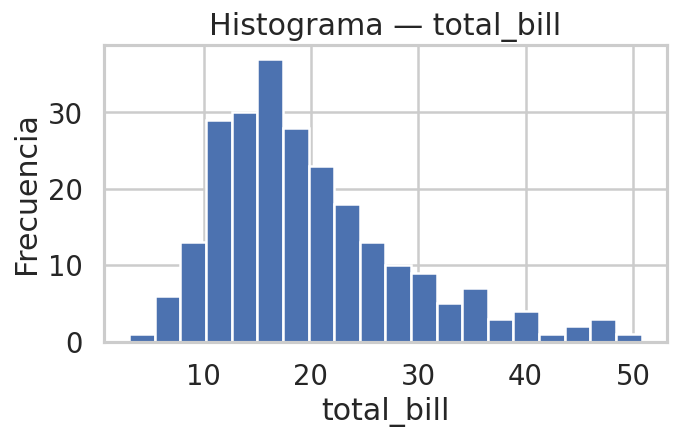

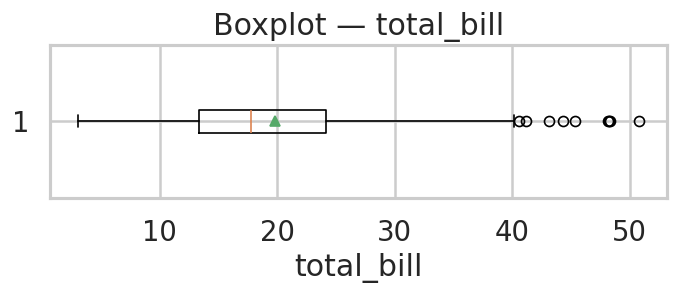

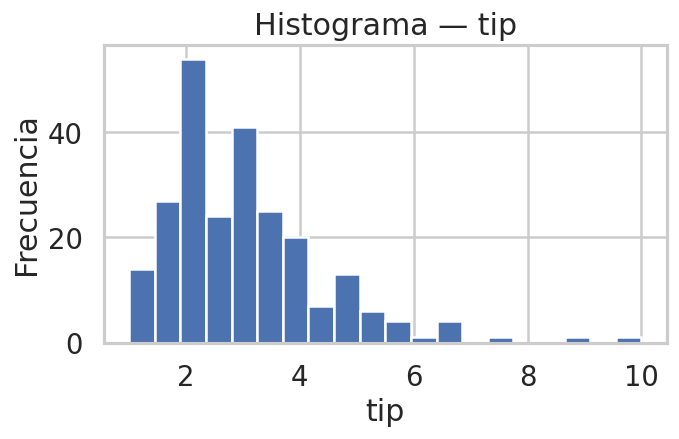

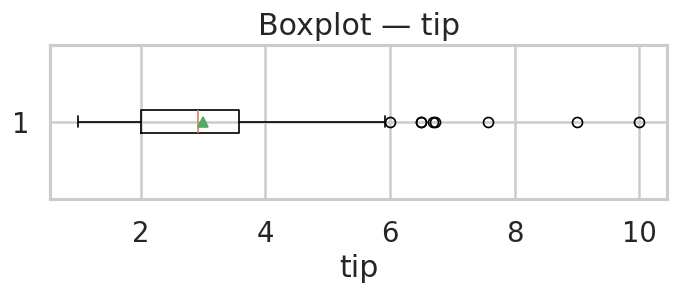

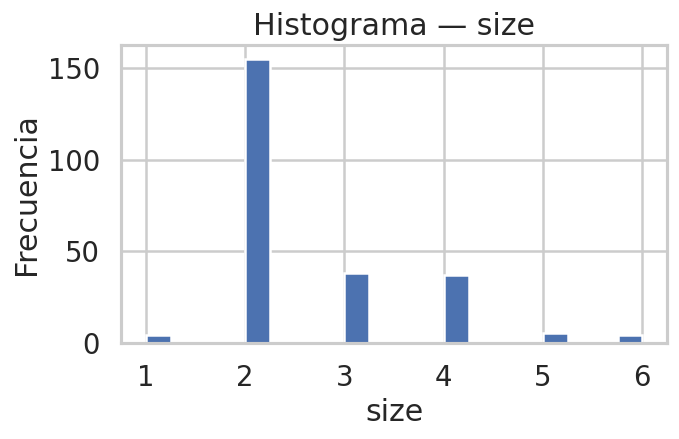

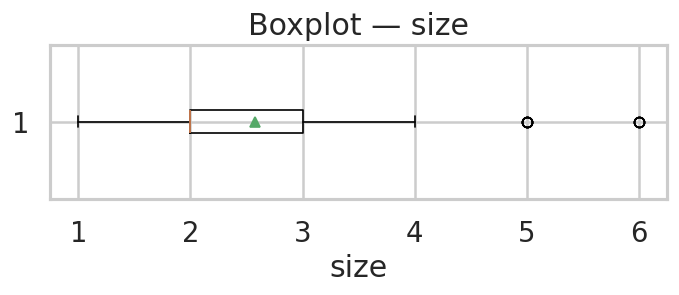

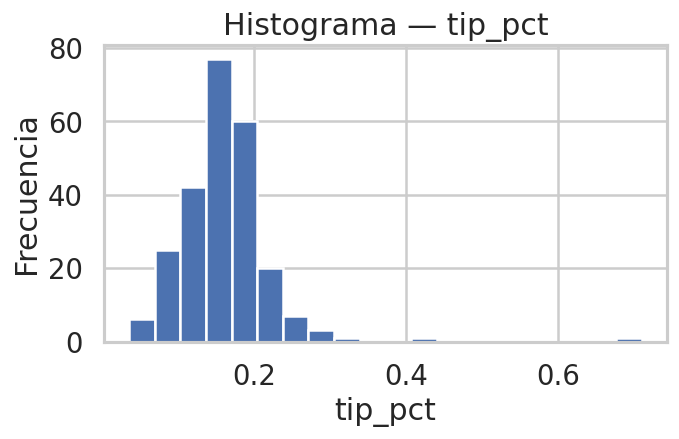

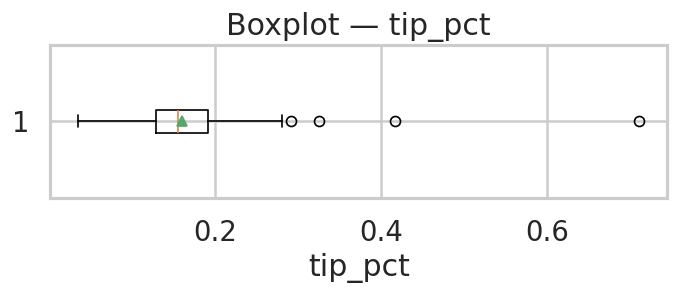

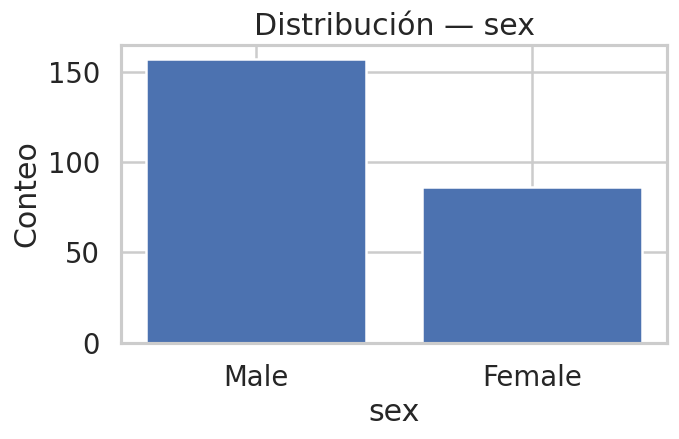

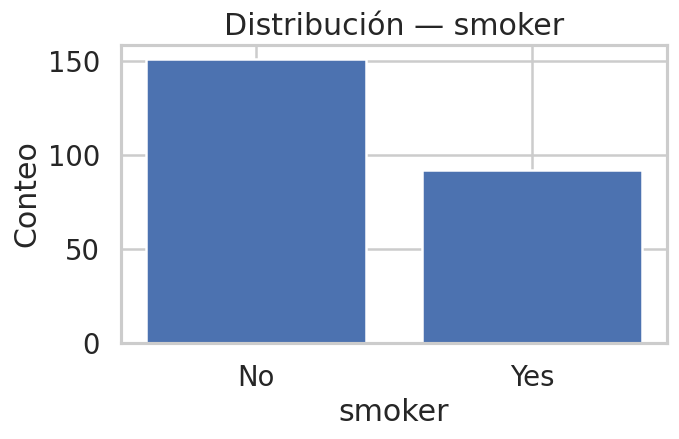

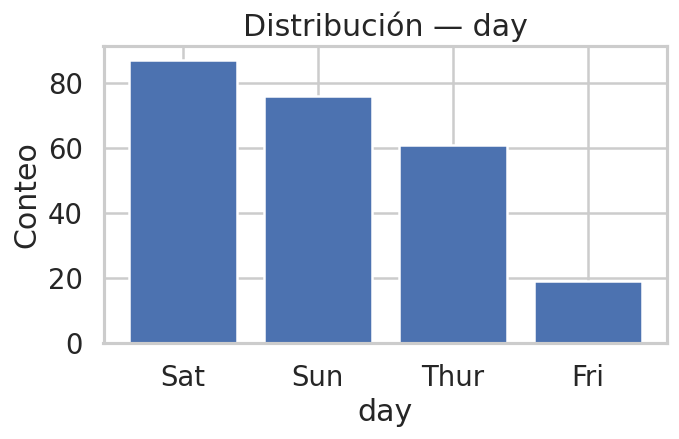

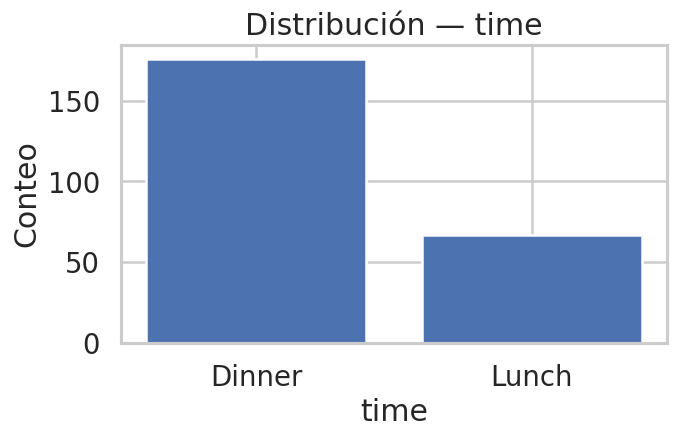

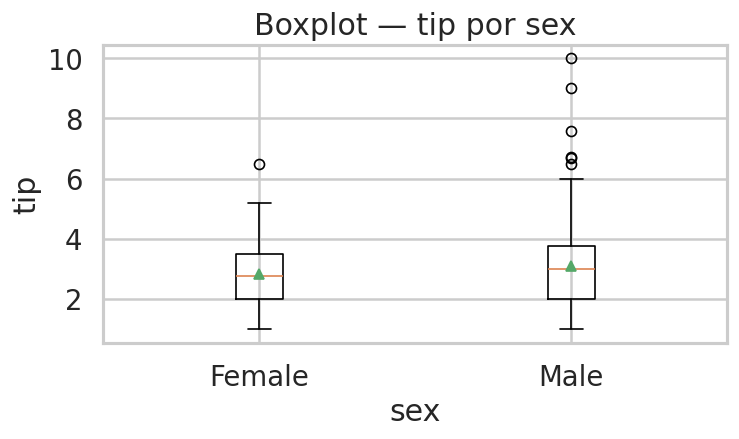

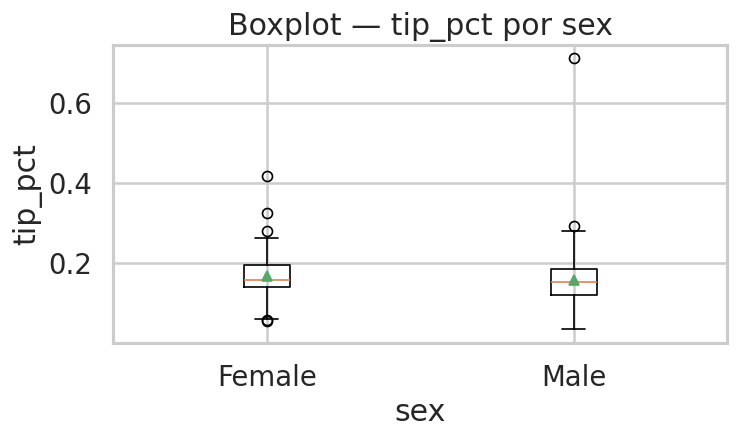

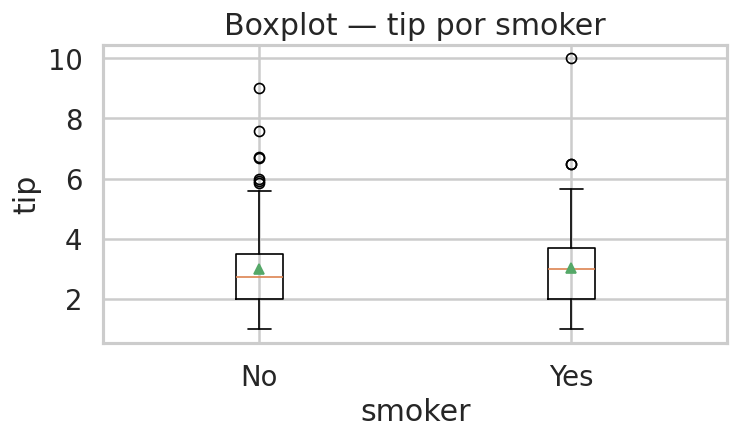

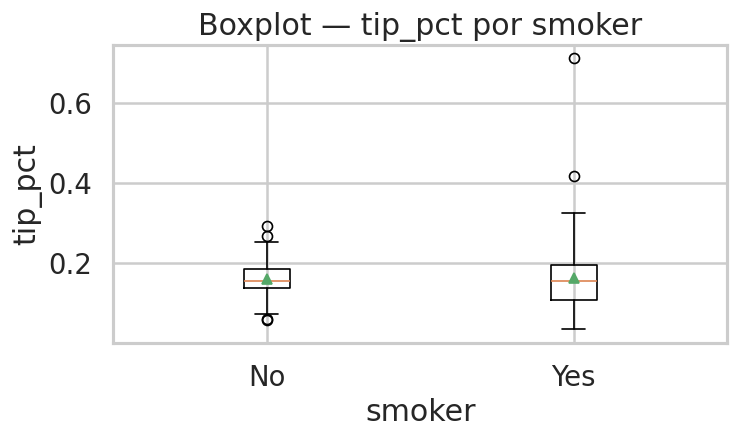

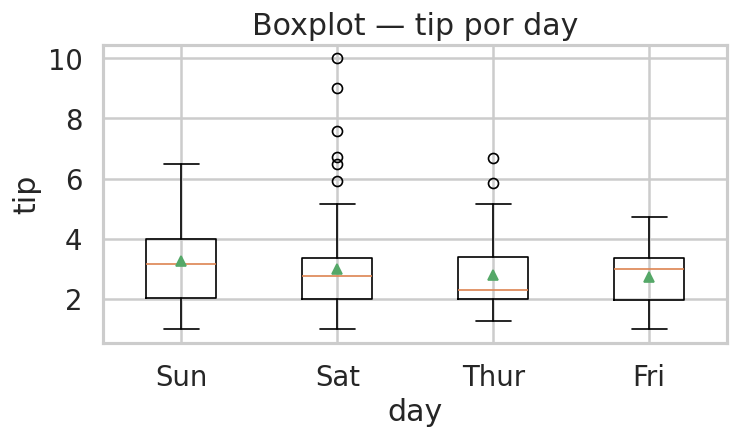

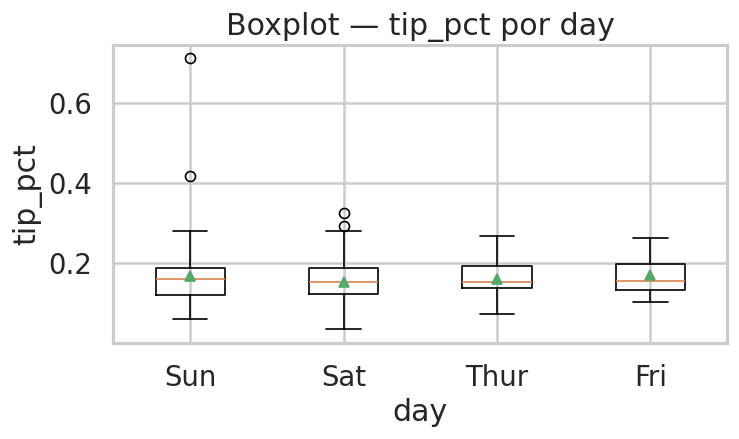

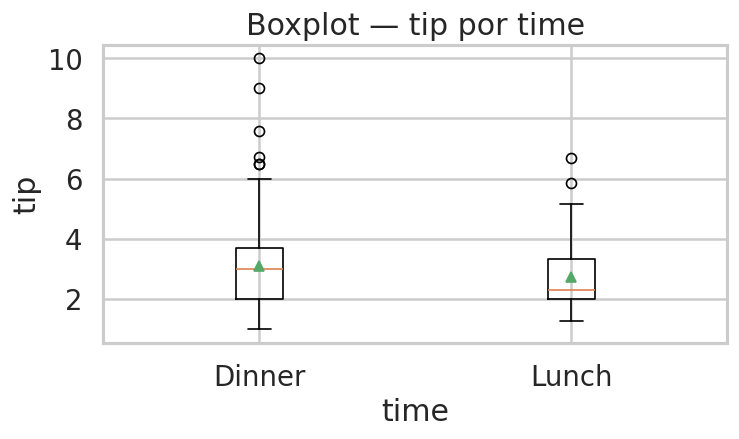

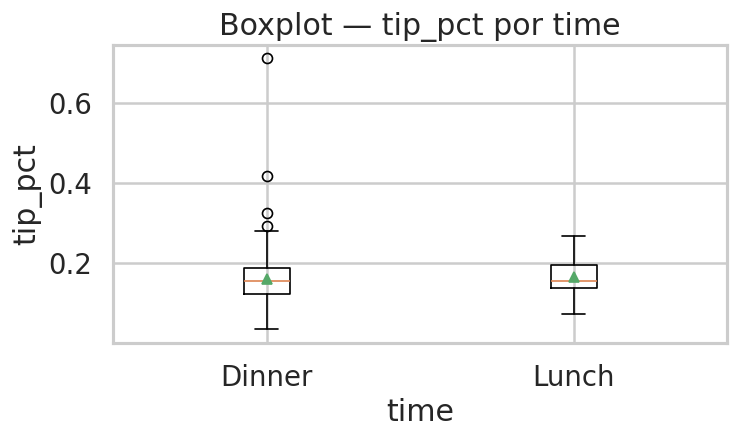

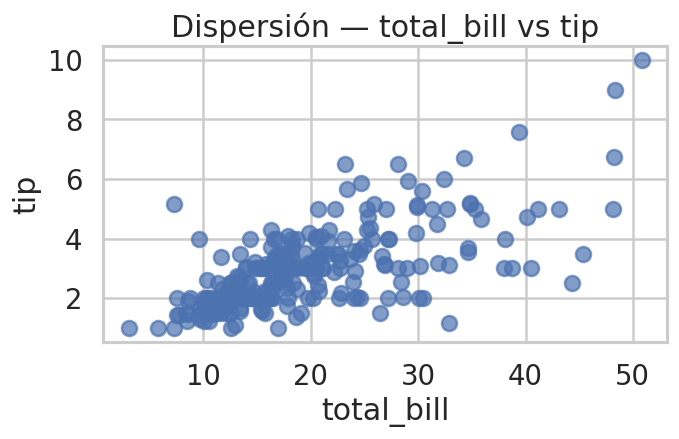

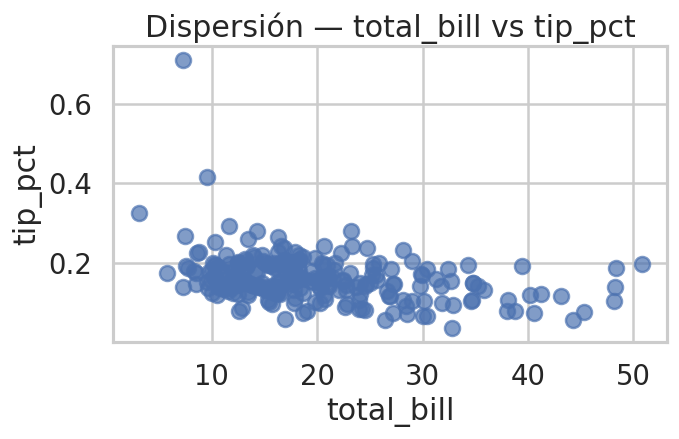

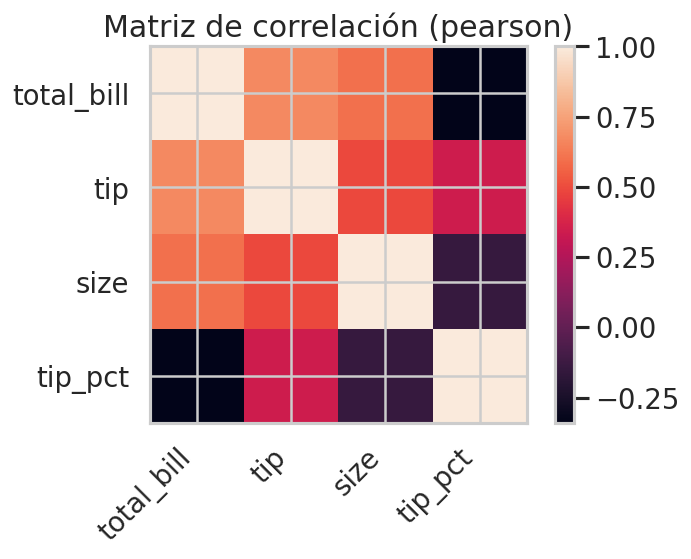

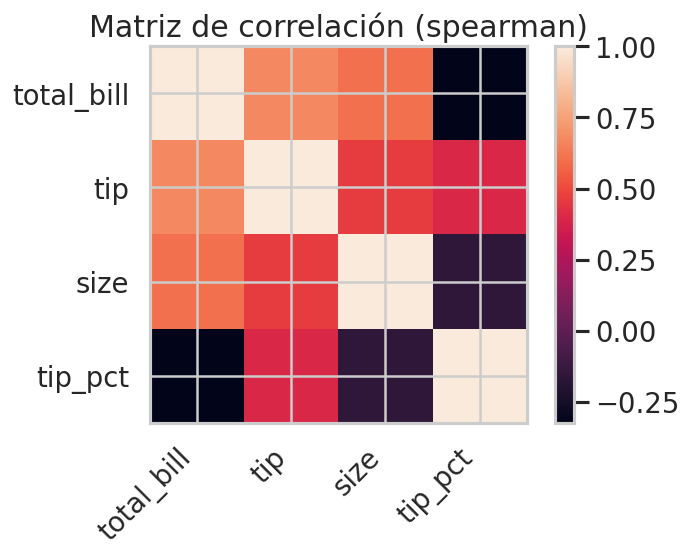

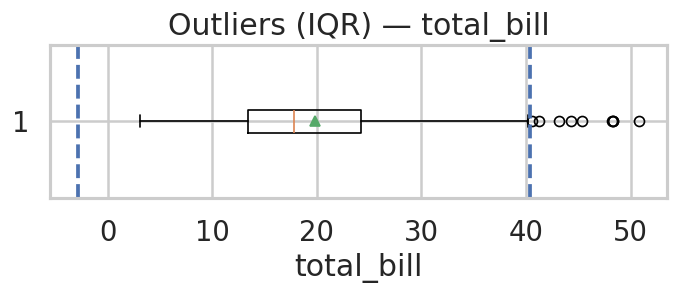

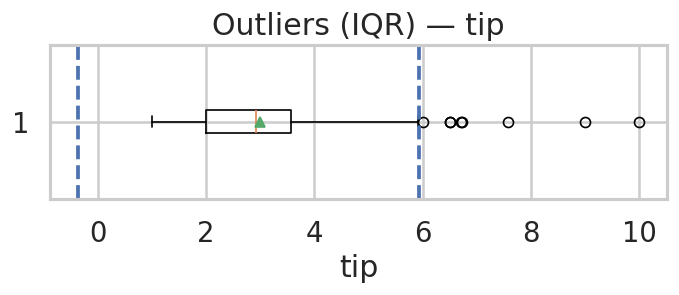

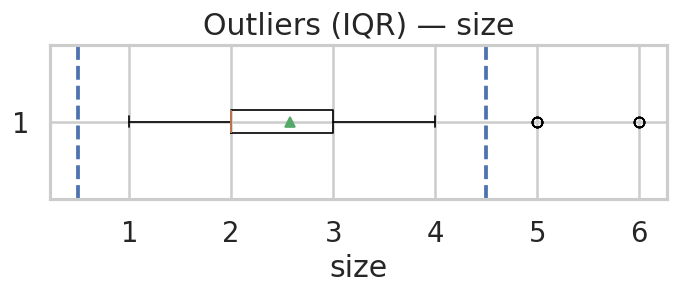

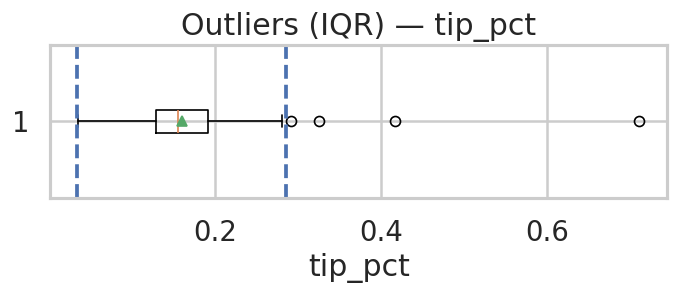

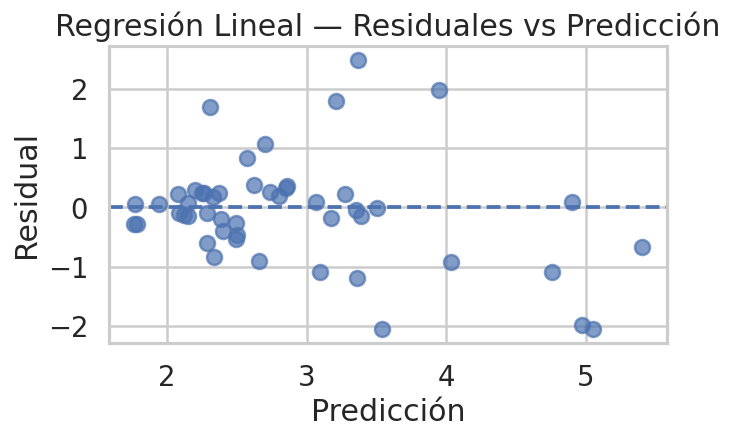

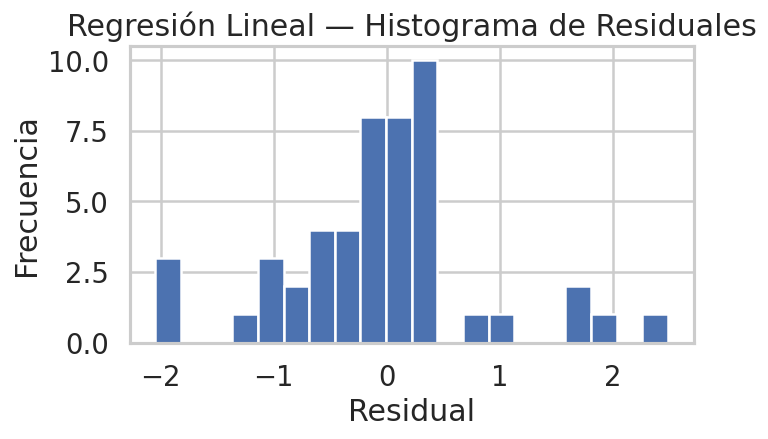

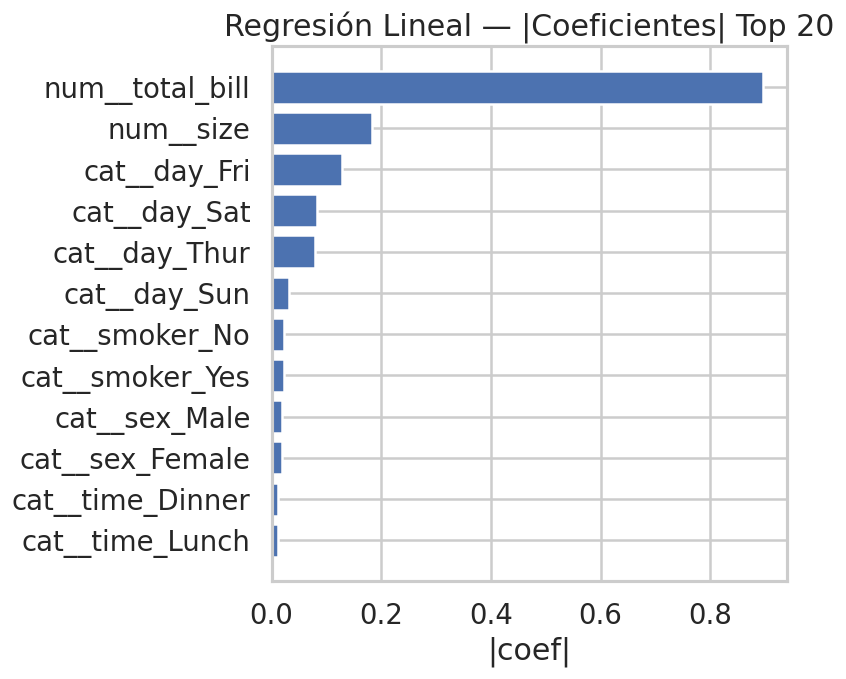

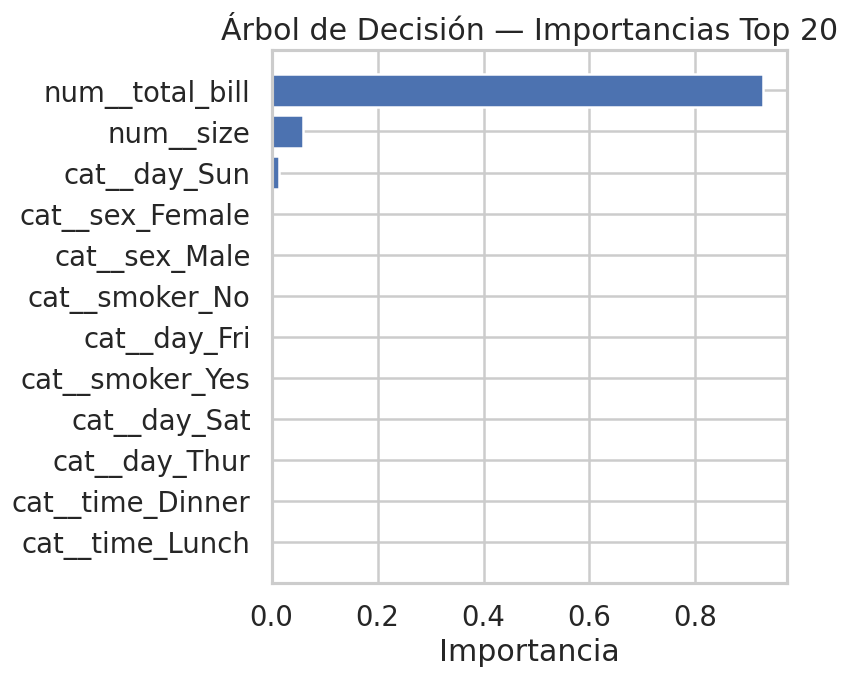

Generando visualización del árbol de decisión (primeros 3 niveles)...


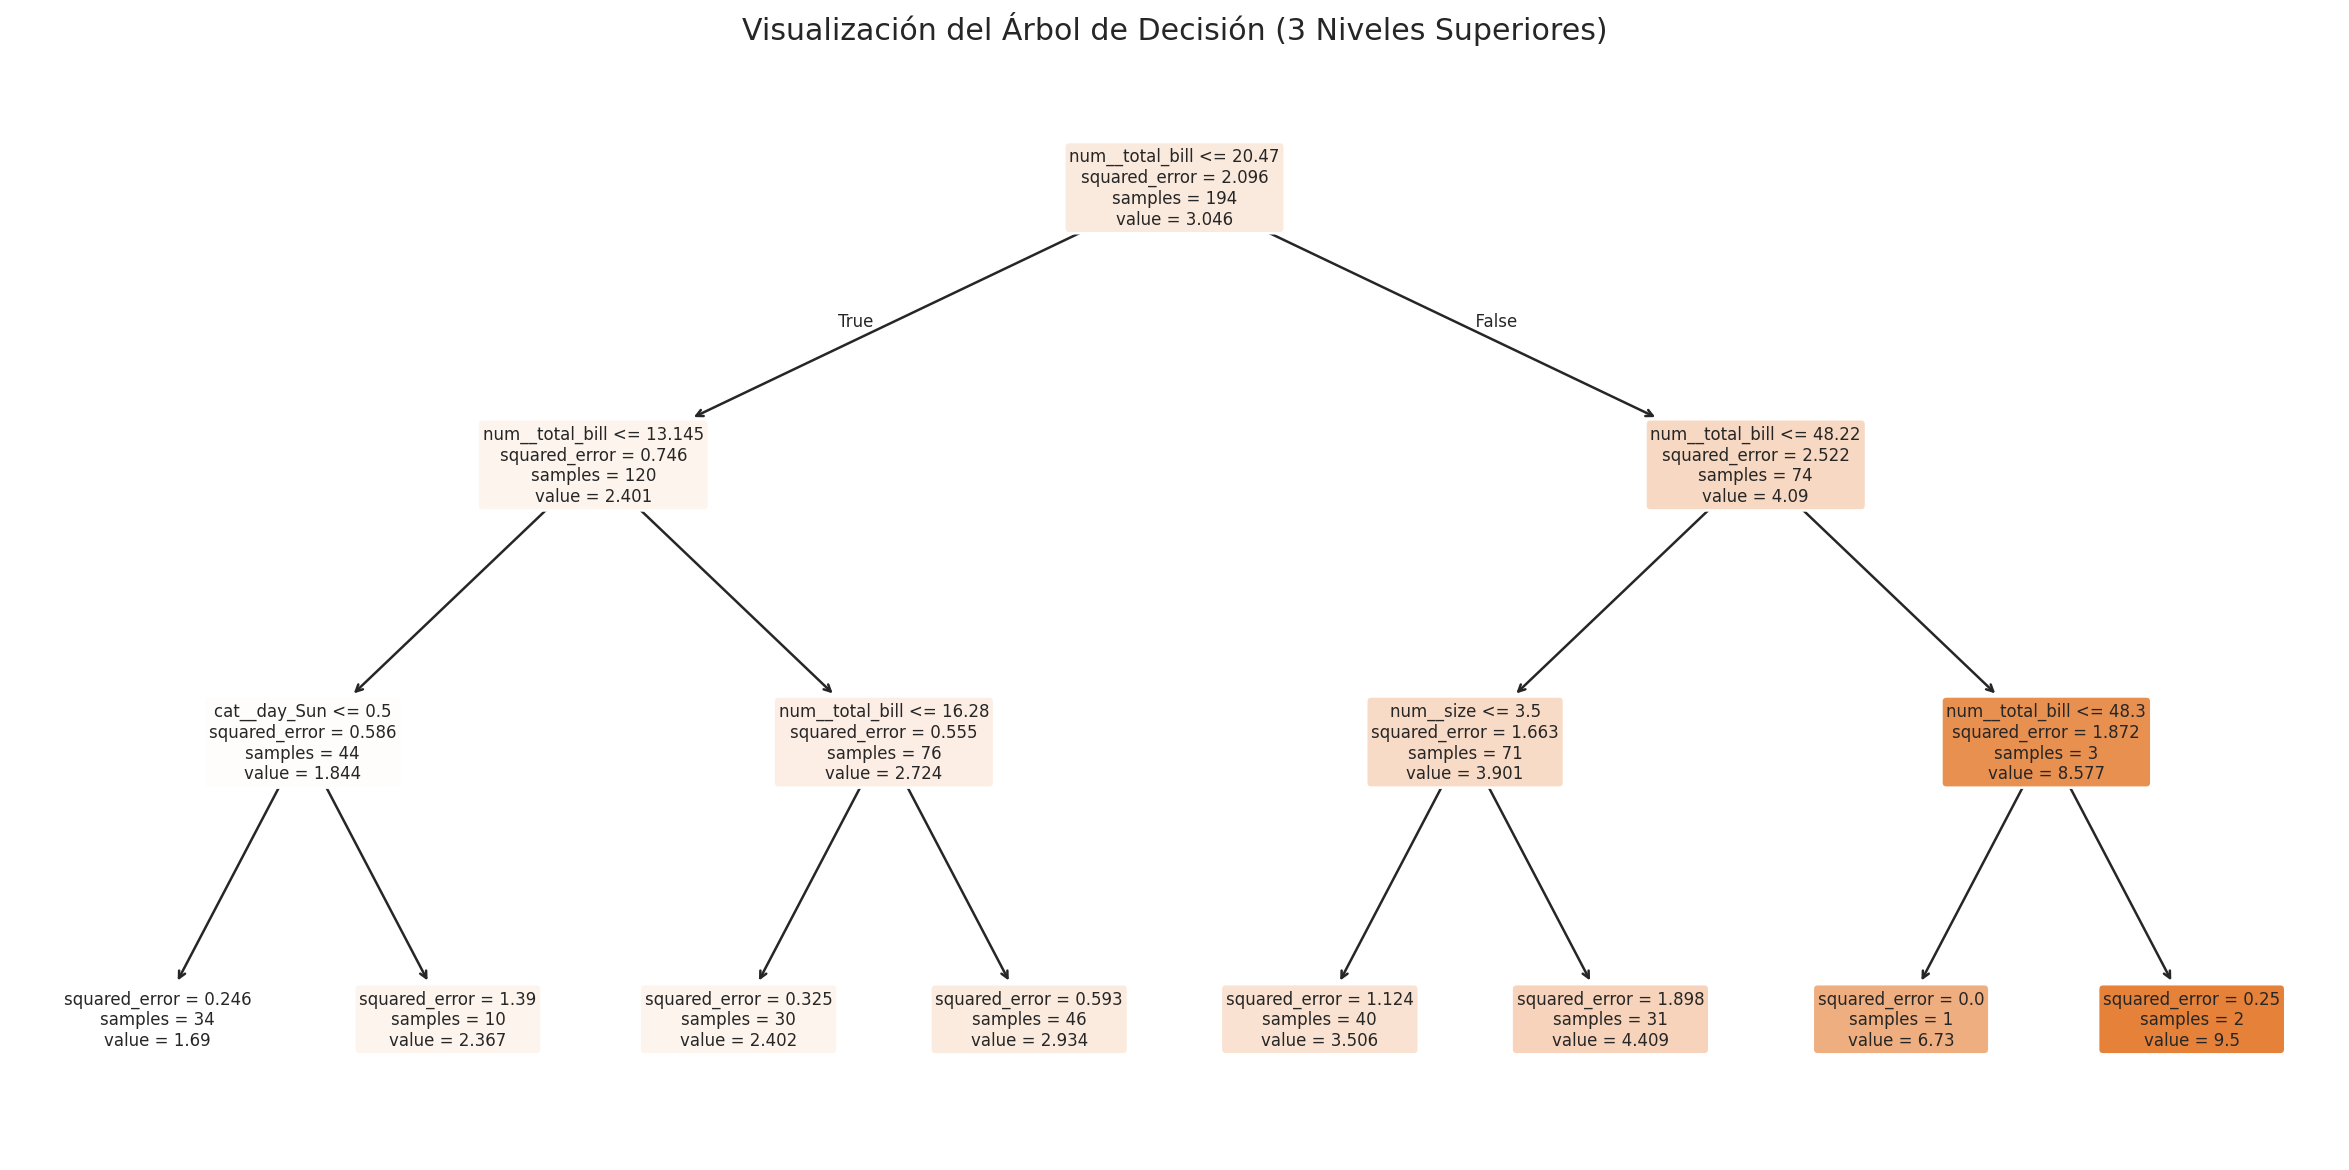


Resumen de métricas (test):
- LR: {
  "r2": 0.2982695027740361,
  "rmse": 0.8935138168564704,
  "mae": 0.6119015590095385
}
- Árbol: {
  "r2": 0.35918563685098936,
  "rmse": 0.8538512442568373,
  "mae": 0.6116940985370305
}

Reporte Markdown: /content/drive/MyDrive/tips_eda_modelado_final/outputs/eda_resumen.md
Figuras: /content/drive/MyDrive/tips_eda_modelado_final/figs
Salidas/CSV: /content/drive/MyDrive/tips_eda_modelado_final/outputs
Visualización del Árbol de Decisión guardada en: /content/drive/MyDrive/tips_eda_modelado_final/figs/tree_visualization.png


In [22]:

# file: colab/tips_eda_modelado_colab.py
"""
EDA completo + Modelado (Regresión Lineal y Árbol de Decisión) del dataset "tips",
adaptado para ejecutarse en **Google Colab** con persistencia opcional en Google Drive.
Incluye: EDA univariada/bivariada, correlaciones (Pearson/Spearman), detección de
anomalías por IQR, Regresión Lineal y Árbol de Decisión (GridSearchCV), métricas,
residuales/importancias y reporte Markdown.

Notas de compatibilidad Colab:
- Evitamos `squared=False` en `mean_squared_error` y calculamos RMSE como `sqrt(MSE)` para
  soportar versiones antiguas de scikit-learn.
- En `cross_validate` usamos `neg_mean_squared_error` y convertimos a RMSE manualmente.
"""
from __future__ import annotations

import json
import sys
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dependencias opcionales (solo carga/red)
try:
    import seaborn as sns  # para load_dataset("tips") si existe
except Exception:  # pragma: no cover
    sns = None  # type: ignore
try:
    import requests  # para fallback GitHub
except Exception:  # pragma: no cover
    requests = None  # type: ignore

# ---------------------- Configuración Colab / Paths ---------------------- #
ROOT: Path
FIG_DIR: Path
OUT_DIR: Path
DISPLAY_INLINE: bool = True  # En Colab: mostrar figuras inline


def in_colab() -> bool:
    return "google.colab" in sys.modules


def ensure_dependencies() -> None:
    """Instala paquetes mínimos en Colab si faltan (por sesiones efímeras)."""
    pkgs = ["pandas", "numpy", "scikit-learn", "matplotlib", "seaborn", "requests"]
    to_install: List[str] = []
    for p in pkgs:
        try:
            __import__(p.replace("-", "_"))
        except Exception:
            to_install.append(p)
    if to_install:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *to_install])


def configure_paths(base_dir_name: str = "tips_eda_modelado", mount_drive: bool = True) -> None:
    """Crea rutas y (opcional) monta Drive para persistir artefactos."""
    global ROOT, FIG_DIR, OUT_DIR, DISPLAY_INLINE
    if in_colab():
        if mount_drive:
            try:
                from google.colab import drive  # type: ignore
                drive.mount("/content/drive")
                root = Path("/content/drive/MyDrive") / base_dir_name
            except Exception:
                root = Path("/content") / base_dir_name
        else:
            root = Path("/content") / base_dir_name
        DISPLAY_INLINE = True
    else:
        root = Path.cwd()
        DISPLAY_INLINE = False
    ROOT = root
    FIG_DIR = ROOT / "figs"
    OUT_DIR = ROOT / "outputs"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    OUT_DIR.mkdir(parents=True, exist_ok=True)


def _savefig(path: Path, *, tight: bool = True) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=150)
    if DISPLAY_INLINE:
        try:
            plt.show()
        except Exception:
            pass
    plt.close()


# ------------------------------ Carga de datos ----------------------------- #

def load_tips_dataset(prefer_seaborn: bool = True, verbose: bool = True) -> pd.DataFrame:
    if prefer_seaborn and sns is not None:
        try:
            if verbose:
                print("Cargando dataset con seaborn.load_dataset('tips') ...")
            return sns.load_dataset("tips")  # type: ignore[attr-defined]
        except Exception as e:
            if verbose:
                print(f"Fallo con seaborn: {e}")
    url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv"
    if requests is not None:
        try:
            if verbose:
                print(f"Descargando dataset desde {url} ...")
            r = requests.get(url, timeout=20)
            r.raise_for_status()
            from io import StringIO
            return pd.read_csv(StringIO(r.text))
        except Exception as e:
            if verbose:
                print(f"Fallo descarga desde GitHub: {e}")
    if verbose:
        print("Generando dataset sintético coherente...")
    return generate_synthetic_tips(n=244, random_state=42)


def generate_synthetic_tips(n: int = 244, random_state: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)
    total_bill = rng.gamma(shape=2.5, scale=8.0, size=n)
    total_bill = np.clip(total_bill, 3, None)
    tip_pct = np.clip(rng.normal(loc=0.16, scale=0.05, size=n), 0.02, 0.35)
    tip = total_bill * tip_pct + rng.normal(0, 0.2, size=n)
    tip = np.clip(tip, 0.5, None)
    size = rng.integers(1, 6, size=n)
    sex = rng.choice(["Male", "Female"], size=n, p=[0.64, 0.36])
    smoker = rng.choice(["Yes", "No"], size=n, p=[0.38, 0.62])
    day = rng.choice(["Thur", "Fri", "Sat", "Sun"], size=n, p=[0.24, 0.12, 0.36, 0.28])
    time = rng.choice(["Lunch", "Dinner"], size=n, p=[0.28, 0.72])
    return pd.DataFrame({
        "total_bill": total_bill,
        "tip": tip,
        "sex": sex,
        "smoker": smoker,
        "day": day,
        "time": time,
        "size": size,
    })


# --------------------------------- Preparación -------------------------------- #

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["sex", "smoker", "day", "time"]:
        if c in df.columns:
            df[c] = df[c].astype("category")
    df["tip_pct"] = df["tip"] / df["total_bill"]
    df = df.drop_duplicates()
    return df


def basic_summary(df: pd.DataFrame) -> Dict[str, object]:
    info = {
        "shape": df.shape,
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing": df.isna().sum().to_dict(),
        "describe_num": df.select_dtypes(include=np.number).describe().to_dict(),
        "describe_cat": {c: df[c].astype("object").value_counts().to_dict() for c in df.select_dtypes("category").columns},
    }
    with open(OUT_DIR / "basic_summary.json", "w", encoding="utf-8") as f:
        json.dump(info, f, ensure_ascii=False, indent=2)
    return info


# --------------------------- EDA: univariado/bivariado --------------------- #

def numeric_and_categorical_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    num_cols = list(df.select_dtypes(include=[np.number]).columns)
    cat_cols = list(df.select_dtypes(include=["category", "object"]).columns)
    return num_cols, cat_cols


def plot_hist_and_box(df: pd.DataFrame, col: str) -> None:
    s = df[col].dropna()
    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=20)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    _savefig(FIG_DIR / f"hist_{col}.png")

    plt.figure(figsize=(6, 2.8))
    plt.boxplot(s, vert=False, showmeans=True)
    plt.title(f"Boxplot — {col}")
    plt.xlabel(col)
    _savefig(FIG_DIR / f"box_{col}.png")


def plot_bar_categorical(df: pd.DataFrame, col: str) -> None:
    counts = df[col].value_counts(dropna=False)
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Distribución — {col}")
    plt.xlabel(col)
    plt.ylabel("Conteo")
    plt.xticks(rotation=0)
    _savefig(FIG_DIR / f"bar_{col}.png")


def box_by_category(df: pd.DataFrame, y: str, by: str) -> None:
    dfg = df[[y, by]].dropna()
    cats = dfg[by].astype(str).unique().tolist()
    data = [dfg[dfg[by].astype(str) == c][y] for c in cats]
    plt.figure(figsize=(6.5, 4))
    plt.boxplot(data, labels=cats, showmeans=True)
    plt.title(f"Boxplot — {y} por {by}")
    plt.xlabel(by)
    plt.ylabel(y)
    _savefig(FIG_DIR / f"box_{y}_por_{by}.png")


def scatter_xy(df: pd.DataFrame, x: str, y: str) -> None:
    dfg = df[[x, y]].dropna()
    plt.figure(figsize=(6, 4))
    plt.scatter(dfg[x], dfg[y], alpha=0.7)
    plt.title(f"Dispersión — {x} vs {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    _savefig(FIG_DIR / f"scatter_{x}_vs_{y}.png")


# -------------------------------- Correlaciones ---------------------------- #

def correlation_matrices(df: pd.DataFrame, methods: Iterable[str] = ("pearson", "spearman")) -> Dict[str, pd.DataFrame]:
    num_cols, _ = numeric_and_categorical_columns(df)
    corrs: Dict[str, pd.DataFrame] = {}
    for m in methods:
        corrs[m] = df[num_cols].corr(method=m)
        corrs[m].to_csv(OUT_DIR / f"correlation_{m}.csv", index=True)
        plt.figure(figsize=(6.5, 5))
        matrix = corrs[m].values
        plt.imshow(matrix, interpolation="nearest")
        plt.title(f"Matriz de correlación ({m})")
        plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
        plt.yticks(range(len(num_cols)), num_cols)
        plt.colorbar()
        _savefig(FIG_DIR / f"corr_heatmap_{m}.png")
    return corrs


# ------------------------------ Outliers por IQR --------------------------- #
@dataclass
class OutlierSummary:
    column: str
    q1: float
    q3: float
    iqr: float
    lower: float
    upper: float
    n_outliers: int


def detect_outliers_iqr(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.copy()
    num_cols, _ = numeric_and_categorical_columns(df)
    summaries: List[OutlierSummary] = []
    for col in num_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        flag_col = f"{col}__is_outlier"
        df[flag_col] = (df[col] < lower) | (df[col] > upper)
        summaries.append(OutlierSummary(col, float(q1), float(q3), float(iqr), float(lower), float(upper), int(df[flag_col].sum())))

        plt.figure(figsize=(6, 2.8))
        plt.boxplot(df[col].dropna(), vert=False, showmeans=True)
        plt.axvline(lower, linestyle="--")
        plt.axvline(upper, linestyle="--")
        plt.title(f"Outliers (IQR) — {col}")
        plt.xlabel(col)
        _savefig(FIG_DIR / f"outliers_{col}.png")

    outlier_cols = [f"{c}__is_outlier" for c in num_cols]
    df["any_outlier"] = df[outlier_cols].any(axis=1)

    summary_df = pd.DataFrame([s.__dict__ for s in summaries])
    summary_df.to_csv(OUT_DIR / "outliers_resumen.csv", index=False)
    return df, summary_df


# ----------------------------------- Modelado -------------------------------- #
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # <-- IMPORTACIÓN AÑADIDA
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


@dataclass
class ModelReport:
    name: str
    cv_metrics: Dict[str, float]
    test_metrics: Dict[str, float]
    extras: Dict[str, object]


def build_preprocessors(df: pd.DataFrame) -> Tuple[ColumnTransformer, ColumnTransformer, List[str], List[str]]:
    num_cols, cat_cols = numeric_and_categorical_columns(df)
    # Excluimos el target (tip) y la variable creada (tip_pct) de las features
    feature_num = [c for c in num_cols if c not in ["tip", "tip_pct"]]
    feature_cat = cat_cols

    pre_lr = ColumnTransformer([
        ("num", StandardScaler(), feature_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cat),
    ])

    pre_tree = ColumnTransformer([
        ("num", "passthrough", feature_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cat),
    ])
    return pre_lr, pre_tree, feature_num, feature_cat


def evaluate_linear_regression(X: pd.DataFrame, y: pd.Series, pre_lr: ColumnTransformer, random_state: int) -> ModelReport:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    pipe = Pipeline([("pre", pre_lr), ("lr", LinearRegression())])

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring={"r2": "r2", "mse": "neg_mean_squared_error", "mae": "neg_mean_absolute_error"},
    )
    cv_metrics = {
        "r2_mean": float(np.mean(cv_scores["test_r2"])),
        "rmse_mean": float(np.sqrt(-np.mean(cv_scores["test_mse"]))),
        "mae_mean": float(-np.mean(cv_scores["test_mae"]))
    }

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_metrics = {
        "r2": float(r2_score(y_test, y_pred)),
        "rmse": float(np.sqrt(test_mse)),
        "mae": float(mean_absolute_error(y_test, y_pred)),
    }

    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, linestyle="--")
    plt.title("Regresión Lineal — Residuales vs Predicción")
    plt.xlabel("Predicción")
    plt.ylabel("Residual")
    _savefig(FIG_DIR / "lr_resid_vs_pred.png")

    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=20)
    plt.title("Regresión Lineal — Histograma de Residuales")
    plt.xlabel("Residual")
    plt.ylabel("Frecuencia")
    _savefig(FIG_DIR / "lr_resid_hist.png")

    lr = pipe.named_steps["lr"]
    pre = pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = [f"f{i}" for i in range(len(lr.coef_))]

    coef = np.asarray(lr.coef_)
    imp = pd.DataFrame({"feature": feature_names, "coef": coef, "abs": np.abs(coef)})
    imp = imp.sort_values("abs", ascending=False).head(20)
    imp.to_csv(OUT_DIR / "lr_coef_top20.csv", index=False)

    plt.figure(figsize=(7, 6))
    plt.barh(imp["feature"][::-1], imp["abs"][::-1])
    plt.title("Regresión Lineal — |Coeficientes| Top 20")
    plt.xlabel("|coef|")
    _savefig(FIG_DIR / "lr_coef_top20.png")

    return ModelReport("LinearRegression", cv_metrics, test_metrics, {"coef_top20": imp.to_dict("records")})


def evaluate_decision_tree(X: pd.DataFrame, y: pd.Series, pre_tree: ColumnTransformer, random_state: int) -> ModelReport:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    pipe = Pipeline([("pre", pre_tree), ("tree", DecisionTreeRegressor(random_state=random_state))])

    param_grid = {
        "tree__max_depth": [3, 5, 7, None],
        "tree__min_samples_leaf": [1, 3, 5, 10],
        "tree__min_samples_split": [2, 5, 10],
    }

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    y_pred = best.predict(X_test)

    test_mse = mean_squared_error(y_test, y_pred)
    test_metrics = {
        "r2": float(r2_score(y_test, y_pred)),
        "rmse": float(np.sqrt(test_mse)),
        "mae": float(mean_absolute_error(y_test, y_pred)),
    }

    tree = best.named_steps["tree"]
    pre = best.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = [f"f{i}" for i in range(len(tree.feature_importances_))]

    importances = pd.DataFrame({"feature": feature_names, "importance": tree.feature_importances_}).sort_values("importance", ascending=False)
    importances.to_csv(OUT_DIR / "tree_importances.csv", index=False)

    top = importances.head(20)
    plt.figure(figsize=(7, 6))
    plt.barh(top["feature"][::-1], top["importance"][::-1])
    plt.title("Árbol de Decisión — Importancias Top 20")
    plt.xlabel("Importancia")
    _savefig(FIG_DIR / "tree_importances_top20.png")

    # --- INICIO: CÓDIGO AÑADIDO PARA VISUALIZAR EL ÁRBOL ---
    print("Generando visualización del árbol de decisión (primeros 3 niveles)...")
    plt.figure(figsize=(25, 12))
    plot_tree(
        best.named_steps["tree"],
        feature_names=feature_names,
        filled=True,
        rounded=True,
        fontsize=10,
        max_depth=3 # Muestra solo los 3 primeros niveles para mayor legibilidad
    )
    plt.title("Visualización del Árbol de Decisión (3 Niveles Superiores)")
    _savefig(FIG_DIR / "tree_visualization.png", tight=False)
    # --- FIN: CÓDIGO AÑADIDO ---

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_validate(best, X_train, y_train, cv=cv, scoring={"r2": "r2", "mse": "neg_mean_squared_error", "mae": "neg_mean_absolute_error"})
    cv_metrics = {
        "r2_mean": float(np.mean(cv_scores["test_r2"])),
        "rmse_mean": float(np.sqrt(-np.mean(cv_scores["test_mse"]))),
        "mae_mean": float(-np.mean(cv_scores["test_mae"]))
    }

    return ModelReport("DecisionTreeRegressor", cv_metrics, test_metrics, {"best_params": grid.best_params_})


# -------------------------------- Reporte Markdown ------------------------- #

def write_markdown_report(
    df: pd.DataFrame,
    basic: Dict[str, object],
    corr: Dict[str, pd.DataFrame],
    outlier_summary: pd.DataFrame,
    model_reports: List[ModelReport],
) -> Path:
    path = OUT_DIR / "eda_resumen.md"
    lines: List[str] = []

    lines.append("# EDA y Modelado — Dataset Tips\n")
    lines.append(f"Generado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    lines.append("## Dataset")
    lines.append(f"- Filas, columnas: **{basic['shape']}**")
    lines.append("- Tipos:")
    for k, v in (basic["dtypes"] or {}).items():
        lines.append(f"  - {k}: {v}")

    lines.append("\n## Valores perdidos")
    miss = basic["missing"] or {}
    tot_miss = int(sum(miss.values())) if isinstance(miss, dict) else 0
    lines.append(f"- Total de celdas con NA: **{tot_miss}**")

    lines.append("\n## Univariado (figuras)")
    for col in df.select_dtypes(include=np.number).columns:
        lines.append(f"- {col}: hist `figs/hist_{col}.png`, box `figs/box_{col}.png`")
    for col in df.select_dtypes(include=["category", "object"]).columns:
        lines.append(f"- {col}: barras `figs/bar_{col}.png`")

    lines.append("\n## Bivariado (figuras)")
    cat_cols = list(df.select_dtypes(include=["category", "object"]).columns)
    for col in ["tip", "tip_pct"]:
        for by in cat_cols:
            if by != col:
                lines.append(f"- {col} por {by}: `figs/box_{col}_por_{by}.png`")
    lines.append("- Dispersión total_bill vs tip: `figs/scatter_total_bill_vs_tip.png`")
    lines.append("- Dispersión total_bill vs tip_pct: `figs/scatter_total_bill_vs_tip_pct.png`")

    lines.append("\n## Correlaciones")
    for m in corr:
        lines.append(f"- Matriz ({m}): `figs/corr_heatmap_{m}.png` y `outputs/correlation_{m}.csv`")

    lines.append("\n## Detección de anomalías (IQR)")
    lines.append("Archivo: `outputs/outliers_resumen.csv`")
    if not outlier_summary.empty:
        lines.append("Top variables con más outliers:")
        top = outlier_summary.sort_values("n_outliers", ascending=False).head(5)
        for _, r in top.iterrows():
            lines.append(f"- {r['column']}: {int(r['n_outliers'])} (IQR={r['iqr']:.3f}, límites=[{r['lower']:.3f}, {r['upper']:.3f}])")

    lines.append("\n## Modelado")
    for rep in model_reports:
        lines.append(f"### {rep.name}")
        lines.append("- CV (media): " + ", ".join([f"{k}={v:.4f}" for k, v in rep.cv_metrics.items()]))
        lines.append("- Test: " + ", ".join([f"{k}={v:.4f}" for k, v in rep.test_metrics.items()]))
        if rep.name == "LinearRegression":
            lines.append("- Coeficientes top20: `outputs/lr_coef_top20.csv` y `figs/lr_coef_top20.png`")
            lines.append("- Residuales: `figs/lr_resid_vs_pred.png`, `figs/lr_resid_hist.png`")
        if rep.name == "DecisionTreeRegressor":
            lines.append("- Mejores hiperparámetros: " + json.dumps(rep.extras.get("best_params", {})))
            lines.append("- Importancias: `outputs/tree_importances.csv` y `figs/tree_importances_top20.png`")
            lines.append("- Visualización del Árbol: `figs/tree_visualization.png`")

    lines.append("\n## Checklist de cumplimiento")
    for item in [
        "EDA variable por variable (hist/box y barras)",
        "Correlaciones (Pearson y Spearman) con heatmaps",
        "Boxplots de tip y tip_pct por categóricas",
        "Dispersión total_bill vs tip y tip_pct",
        "Anomalías vía IQR + resumen",
        "Regresión Lineal con CV, métricas y residuales",
        "Árbol de Decisión con GridSearchCV, métricas, importancias y visualización",
        "Artefactos guardados en figs/ y outputs/",
    ]:
        lines.append(f"- [x] {item}")

    path.write_text("\n".join(lines), encoding="utf-8")
    return path


# -------------------------------------- Main -------------------------------- #

def run(random_state: int = 7, *, mount_drive: bool = True, base_dir_name: str = "tips_eda_modelado") -> Dict[str, object]:
    if in_colab():
        print("Detectado Google Colab. Configurando entorno y dependencias...")
        ensure_dependencies()
    configure_paths(base_dir_name=base_dir_name, mount_drive=mount_drive)
    print(f"ROOT: {ROOT}")

    df_raw = load_tips_dataset(prefer_seaborn=True)
    df = preprocess(df_raw)

    basic = basic_summary(df)

    num_cols, cat_cols = numeric_and_categorical_columns(df)
    for col in num_cols:
        plot_hist_and_box(df, col)
    for col in cat_cols:
        plot_bar_categorical(df, col)

    for by in cat_cols:
        box_by_category(df, "tip", by)
        box_by_category(df, "tip_pct", by)

    scatter_xy(df, "total_bill", "tip")
    scatter_xy(df, "total_bill", "tip_pct")

    corr = correlation_matrices(df)

    df_out, out_summary = detect_outliers_iqr(df)
    df_out.to_csv(OUT_DIR / "tips_con_outliers_flags.csv", index=False)

    pre_lr, pre_tree, _, _ = build_preprocessors(df)
    X = df.drop(columns=["tip", "tip_pct"])  # Excluimos target y variables creadas de las features
    y = df["tip"]

    rep_lr = evaluate_linear_regression(X, y, pre_lr, random_state)
    rep_tree = evaluate_decision_tree(X, y, pre_tree, random_state)

    report_path = write_markdown_report(df, basic, corr, out_summary, [rep_lr, rep_tree])

    print("\nResumen de métricas (test):")
    print("- LR:", json.dumps(rep_lr.test_metrics, indent=2))
    print("- Árbol:", json.dumps(rep_tree.test_metrics, indent=2))
    print(f"\nReporte Markdown: {report_path}")
    print(f"Figuras: {FIG_DIR}")
    print(f"Salidas/CSV: {OUT_DIR}")
    print(f"Visualización del Árbol de Decisión guardada en: {FIG_DIR / 'tree_visualization.png'}")


    return {
        "linear_regression": rep_lr.test_metrics,
        "decision_tree": rep_tree.test_metrics,
        "report": str(report_path),
        "fig_dir": str(FIG_DIR),
        "out_dir": str(OUT_DIR),
    }


if __name__ == "__main__":
    _ = run(random_state=7, mount_drive=True, base_dir_name="tips_eda_modelado_final")

In [25]:
# Colab/Jupyter: render de HTML+CSS+JS con toggle de tema y burbujas
from IPython.display import HTML, display

texto = """

<p>Vamos a interpretarlo paso a paso, siguiendo las decisiones desde la raíz (el nodo superior) hacia abajo.</p>

<h3>Interpretación General</h3>
<p>El árbol funciona como un juego de “adivina quién” con los datos. En cada caja (nodo), hace una pregunta (una condición True/False) para dividir los datos en dos grupos más pequeños y homogéneos. El objetivo es llegar a nodos finales (hojas) donde todas las muestras tengan un valor de propina similar.</p>
<ul>
  <li><strong>value</strong>: Es la predicción de la propina (en dólares) para todas las muestras que caen en ese nodo.</li>
  <li><strong>color</strong>: El color se vuelve más oscuro (naranja intenso) a medida que el <em>value</em> (la propina predicha) aumenta.</li>
</ul>

<h3>Recorrido por el Árbol (Ejemplos)</h3>
<h4>Nodo Raíz (La primera y más importante decisión)</h4>
<p><strong>Condición:</strong> <code>num_total_bill &lt;= 20.47</code></p>
<p><strong>Interpretación:</strong> La primera pregunta que se hace el modelo es: “¿La cuenta total es de $20.47 o menos?”. Esto confirma lo que vimos en el gráfico de importancia: el total de la cuenta es el factor más decisivo.</p>
<ul>
  <li>Si la respuesta es <em>Sí (True)</em>, seguimos por la izquierda.</li>
  <li>Si la respuesta es <em>No (False)</em>, seguimos por la derecha.</li>
</ul>

<h4>Escenario 1: Una cuenta pequeña (Ej: $15)</h4>
<ol>
  <li><strong>Nodo Raíz:</strong> ¿15 &lt;= 20.47? <em>Sí (True)</em>. Vamos a la izquierda.</li>
  <li><strong>Segundo Nodo (Izquierda):</strong> ¿<code>num_total_bill &lt;= 13.145</code>?</li>
  <li>Como la cuenta es $15, la respuesta es <em>No (False)</em>. Vamos a la derecha de este nodo.</li>
  <li><strong>Tercer Nodo (Centro-Izquierda):</strong> ¿<code>num_total_bill &lt;= 16.28</code>?</li>
  <li>$15 cumple la condición → <em>Sí (True)</em>. Vamos a la izquierda.</li>
  <li><strong>Nodo Final (Hoja):</strong> Predicción <strong>(value)</strong>: <strong>$2.402</strong>. Basado en 30 muestras con estas condiciones.</li>
</ol>

<h4>Escenario 2: Una cuenta grande con un grupo grande (Ej: $35 para 4 personas)</h4>
<ol>
  <li><strong>Nodo Raíz:</strong> ¿35 &lt;= 20.47? <em>No (False)</em>. Vamos a la derecha.</li>
  <li><strong>Segundo Nodo (Derecha):</strong> ¿<code>num_total_bill &lt;= 48.22</code>?</li>
  <li>$35 cumple → <em>Sí (True)</em>. Vamos a la izquierda.</li>
  <li><strong>Tercer Nodo (Centro-Derecha):</strong> ¿<code>num_size &lt;= 3.5</code>?</li>
  <li>El grupo es 4 → <em>No (False)</em>. Vamos a la derecha.</li>
  <li><strong>Nodo Final (Hoja):</strong> Predicción <strong>(value)</strong>: <strong>$4.409</strong>. Nodo más oscuro = propina más alta.</li>
</ol>

<h3>Conclusiones Clave del Árbol</h3>
<ul>
  <li><strong>Jerarquía de Decisiones:</strong> Primero segmenta por <code>total_bill</code> (barato/medio/caro). Luego usa <code>num_size</code> o <code>cat_day_Sun</code> para ajustes finos.</li>
  <li><strong>Reglas Aprendidas:</strong>
    <ul>
      <li>Cuentas más altas → propinas más altas (la rama derecha tiene valores más altos).</li>
      <li>Para cuentas caras (20–48), grupos grandes (<code>num_size &gt; 3</code>) tienden a dejar propinas más altas en <em>valor absoluto</em>.</li>
      <li>Para cuentas muy baratas (&lt; $13), los domingos (<code>cat_day_Sun &gt; 0.5</code>) son levemente más generosos que otros días.</li>
    </ul>
  </li>
  <li><strong>Potencial de Sobreajuste (Overfitting):</strong> El nodo extremo derecho usa solo 3 muestras. Esas reglas específicas pueden no generalizar. Conviene limitar <code>max_depth</code> o subir <code>min_samples_leaf</code>. Un <em>GridSearchCV</em> ayuda a elegir bien.</li>
</ul>
"""

html = f"""
<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8">
<meta name="viewport" content="width=device-width,initial-scale=1.0">
<title>Árbol de Decisión — Interpretación</title>
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;800&display=swap" rel="stylesheet">
<style>
  :root {{
    --bg: linear-gradient(135deg,#f5f7ff 0%, #eef2ff 100%);
    --card: #ffffff;
    --text: #1f2937;
    --muted: #4b5563;
    --accent: #6d28d9;
    --ring: rgba(109,40,217,.15);
    --shadow: 0 20px 40px rgba(0,0,0,.10);
  }}
  [data-theme="dark"] {{
    --bg: radial-gradient(1200px 600px at 10% 10%, #0b1020 0%, #050713 45%, #03040b 100%);
    --card: #0f172a;
    --text: #e5e7eb;
    --muted: #9ca3af;
    --accent: #60a5fa;
    --ring: rgba(96,165,250,.18);
    --shadow: 0 20px 50px rgba(0,0,0,.45);
  }}
  * {{ box-sizing: border-box; }}
  html,body {{ margin:0; height:100%; }}
  body {{
    font-family: 'Inter', system-ui, -apple-system, Segoe UI, Roboto, sans-serif;
    background: var(--bg);
    color: var(--text);
    line-height: 1.7;
    overflow-x: hidden;
  }}

  /* Burbujas de fondo */
  .bubbles {{
    position: fixed; inset: 0; overflow: hidden; z-index: 0; pointer-events: none;
  }}
  .bubble {{
    position: absolute; bottom: -120px; width: var(--s); height: var(--s);
    background: radial-gradient(circle at 30% 30%, rgba(255,255,255,.9), rgba(255,255,255,0.05));
    border-radius: 50%;
    filter: blur(0.4px);
    animation: floatUp var(--t) linear infinite;
    opacity: .45;
    box-shadow: inset 0 0 20px rgba(255,255,255,.35), 0 8px 25px var(--ring);
  }}
  @keyframes floatUp {{
    0%   {{ transform: translateY(0) translateX(0) scale(1); opacity:.0; }}
    5%   {{ opacity:.45; }}
    100% {{ transform: translateY(-115vh) translateX(var(--x)) scale(1.06); opacity:0; }}
  }}

  .wrap {{ position: relative; z-index: 1; max-width: 980px; margin: 0 auto; padding: 32px 16px 56px; }}
  .header {{
    display:flex; align-items:center; justify-content:space-between; gap:12px; margin-bottom: 18px;
  }}
  .title {{
    font-size: clamp(1.6rem, 2.8vw, 2.2rem);
    font-weight: 800; letter-spacing: .2px;
    background: linear-gradient(135deg, var(--accent), #8b5cf6);
    -webkit-background-clip:text; -webkit-text-fill-color: transparent; background-clip:text;
    margin: 0;
  }}
  .toggle {{
    border: 1.5px solid rgba(255,255,255,.18);
    background: var(--card);
    color: var(--text);
    border-radius: 999px; padding: 10px 14px; cursor: pointer; font-weight: 600;
    box-shadow: var(--shadow);
  }}
  .card {{
    background: var(--card);
    border: 1px solid rgba(255,255,255,.10);
    box-shadow: var(--shadow);
    border-radius: 18px;
    padding: 22px 22px;
  }}
  .prose h2 {{ margin: 0 0 6px; font-size: 1.45rem; }}
  .prose h3 {{ margin: 22px 0 10px; font-size: 1.18rem; }}
  .prose h4 {{ margin: 16px 0 6px; font-size: 1.05rem; }}
  .prose p  {{ margin: 8px 0; color: var(--text); }}
  .prose ul, .prose ol {{ margin: 6px 0 10px 22px; color: var(--text); }}
  code {{ background: rgba(0,0,0,.06); padding: 2px 6px; border-radius: 8px; }}
  [data-theme="dark"] code {{ background: rgba(255,255,255,.06); }}
  .footer {{
    margin-top: 14px; font-size: .92rem; color: var(--muted); text-align:center;
  }}
</style>
</head>
<body>
  <!-- Fondo de burbujas -->
  <div class="bubbles" id="bubbles"></div>

  <div class="wrap">
    <div class="header">
      <h1 class="title">Árbol de Decisión — Interpretación Visual</h1>
      <button class="toggle" id="themeBtn" aria-label="Cambiar tema">🌙 Tema</button>
    </div>

    <div class="card prose" id="content">
      {texto}
      <div class="footer">Tip: limitá <code>max_depth</code> y/o subí <code>min_samples_leaf</code> para reducir sobreajuste.</div>
    </div>
  </div>

<script>
  // Toggle de tema
  const btn = document.getElementById('themeBtn');
  btn.addEventListener('click', () => {{
    const dark = document.body.getAttribute('data-theme') === 'dark';
    if (dark) {{
      document.body.removeAttribute('data-theme');
      btn.textContent = '🌙 Tema';
    }} else {{
      document.body.setAttribute('data-theme', 'dark');
      btn.textContent = '☀️ Tema';
    }}
  }});

  // Burbujas dinámicas
  const cont = document.getElementById('bubbles');
  function spawnBubble() {{
    const b = document.createElement('div');
    b.className = 'bubble';
    const size  = Math.random()*40 + 16;        // 16–56px
    const left  = Math.random()*100;            // 0–100 vw
    const time  = Math.random()*9 + 8;          // 8–17s
    const drift = (Math.random()*120 - 60) + 'px'; // -60–60px
    b.style.setProperty('--s', size+'px');
    b.style.left = left + 'vw';
    b.style.setProperty('--t', time + 's');
    b.style.setProperty('--x', drift);
    cont.appendChild(b);
    setTimeout(() => cont.removeChild(b), time*1000);
  }}
  // frecuencia de aparición
  setInterval(spawnBubble, 380);
  for (let i=0; i<10; i++) setTimeout(spawnBubble, i*250); // arranque suave
</script>
</body>
</html>
"""

display(HTML(html))
